<a href="https://colab.research.google.com/github/abdmomin/sentiment_analysis/blob/master/sentiment_aanalysis_amz_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

## Imports

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.utils import shuffle

## Create a class to manipulate data

In [ ]:
class Sentiment:
  POSITIVE = 'POSITIVE'
  NEUTRAL = 'NEUTRAL'
  NEGATIVE = 'NEGATIVE'

class Review:
  def __init__(self, text, rating):
    self.text = text
    self.rating = rating
    self.sentiment = self.get_sentiment()

  def get_sentiment(self):
    if self.rating <= 2:
      return Sentiment.NEGATIVE
    elif self.rating == 3:
      return Sentiment.NEUTRAL
    else:
      return Sentiment.POSITIVE

class RatingCount:
  def __init__(self, reviews):
    self.reviews = reviews

  def get_reviews(self):
    return [x.text for x in self.reviews]

  def get_labels(self):
    return [x.sentiment for x in self.reviews]

  def divide_rating(self):
    negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
    positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
    neutral = list(filter(lambda x: x.sentiment == Sentiment.NEUTRAL, self.reviews))

    self.reviews = negative + positive[:len(negative)] + neutral
    shuffle(self.reviews)

## Read the data

In [ ]:
file_paths = []
for file_path in os.listdir('.'):
  if file_path.endswith('.csv'):
    file_paths.append(file_path)

dfs = [pd.read_csv(path) for path in file_paths]
df = pd.concat(dfs, axis=0, ignore_index=True)
df.head()

,title,rating,review
0,Love,5.0,Sable killed Lalya and shot Leeds. Lalya and S...
1,Shame on you Leeds! Oh wait! What?!,4.0,"I spent 70% of this book hating Leeds for ""che..."
2,It must be 11am!,5.0,I’m compelled to write this review but I feel ...
3,Outside My Usual and No Regrets!,5.0,It's hard to explain this book without giving ...
4,Glad I stuck with it!,4.0,I found the beginning to be tough to hold my i...


In [ ]:
df.shape

(5815, 3)

In [ ]:
df['review_text'] = df['title'] + ' ' + df['review']
df.head()

,title,rating,review,review_text
0,Love,5.0,Sable killed Lalya and shot Leeds. Lalya and S...,Love Sable killed Lalya and shot Leeds. Lalya ...
1,Shame on you Leeds! Oh wait! What?!,4.0,"I spent 70% of this book hating Leeds for ""che...",Shame on you Leeds! Oh wait! What?! I spent 70...
2,It must be 11am!,5.0,I’m compelled to write this review but I feel ...,It must be 11am! I’m compelled to write this r...
3,Outside My Usual and No Regrets!,5.0,It's hard to explain this book without giving ...,Outside My Usual and No Regrets! It's hard to ...
4,Glad I stuck with it!,4.0,I found the beginning to be tough to hold my i...,Glad I stuck with it! I found the beginning to...


In [ ]:
data = df[['review_text', 'rating']].copy()

In [ ]:
data['review_text'] = data['review_text'].str.lower().str.replace('[^a-zA-Z ]', '', regex=True)

In [ ]:
data.head()

,review_text,rating
0,love sable killed lalya and shot leeds lalya a...,5.0
1,shame on you leeds oh wait what i spent of th...,4.0
2,it must be am im compelled to write this revie...,5.0
3,outside my usual and no regrets its hard to ex...,5.0
4,glad i stuck with it i found the beginning to ...,4.0


In [ ]:
data.isna().sum()

review_text    1249
rating         1244
dtype: int64

In [ ]:
data.dropna(inplace=True)

In [ ]:
data.dtypes

review_text     object
rating         float64
dtype: object

In [ ]:
data.rating.value_counts()

5.0    2912
4.0     766
3.0     476
2.0     223
1.0     189
Name: rating, dtype: int64

In [ ]:
reviews = []
for rows in data.itertuples():
  reviews.append(Review(rows[1], rows[2]))

## Naive Bayes models

In [ ]:
train_set, test_set = train_test_split(reviews, test_size=0.2)

train_data = RatingCount(train_set)
test_data = RatingCount(test_set)

train_data.divide_rating()
X_train = train_data.get_reviews()
y_train = train_data.get_labels()

test_data.divide_rating()
X_test = test_data.get_reviews()
y_test = test_data.get_labels()

In [ ]:
naive_model = Pipeline([
    ('count_vec', CountVectorizer()),
    ('multi_nb', MultinomialNB())
])

naive_model.fit(X_train, y_train)
print(X_test[0])
naive_model.predict([X_test[0]])

did not like book do not like paranormal storiesdid not finish book


array(['NEGATIVE'], dtype='<U8')

In [ ]:
type(y_train[0])

str

## Evaluate the model

In [ ]:
naive_model.score(X_train, y_train)

0.8923809523809524

In [ ]:
naive_model.score(X_test, y_test)

0.644

In [ ]:
y_pred = naive_model.predict(X_test)

In [ ]:
f1_score(y_test, y_pred, average=None, labels=[Sentiment.POSITIVE, Sentiment.NEUTRAL, Sentiment.NEGATIVE])

array([0.76595745, 0.63865546, 0.51239669])

In [ ]:
testing = ['this is a great book, i loved it', "the book so bad", 'horrible product, total waste of money']
naive_model.predict(testing)

array(['POSITIVE', 'NEGATIVE', 'NEGATIVE'], dtype='<U8')

## Deep learning model

In [ ]:
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
data.head()

,review_text,rating
0,love sable killed lalya and shot leeds lalya a...,5.0
1,shame on you leeds oh wait what i spent of th...,4.0
2,it must be am im compelled to write this revie...,5.0
3,outside my usual and no regrets its hard to ex...,5.0
4,glad i stuck with it i found the beginning to ...,4.0


In [ ]:
!wget -q https://raw.githubusercontent.com/KeithGalli/sklearn/master/data/sentiment/Books_small_10000.json

In [ ]:
review_data = []
with open('Books_small_10000.json', 'r') as f:
  for line in f:
    json_data = json.loads(line)
    review_data.append({'review_text': json_data['reviewText'], 'rating': json_data['overall']})

json_df = pd.DataFrame(review_data)

In [ ]:
json_df.shape

(10000, 2)

In [ ]:
full_df = pd.concat([data, json_df], axis=0, ignore_index=True)
full_df.head()

,review_text,rating
0,love sable killed lalya and shot leeds lalya a...,5.0
1,shame on you leeds oh wait what i spent of th...,4.0
2,it must be am im compelled to write this revie...,5.0
3,outside my usual and no regrets its hard to ex...,5.0
4,glad i stuck with it i found the beginning to ...,4.0


In [ ]:
full_df.shape

(14566, 2)

In [ ]:
full_df['review_text'] = full_df['review_text'].str.lower().str.replace('[^a-zA-Z ]', '', regex=True)

In [ ]:
new_data = full_df.copy()

new_data['rate_point'] = new_data['rating'].apply(lambda x: 1 if x >= 4 else 0)
new_data.head()

,review_text,rating,rate_point
0,love sable killed lalya and shot leeds lalya a...,5.0,1
1,shame on you leeds oh wait what i spent of th...,4.0,1
2,it must be am im compelled to write this revie...,5.0,1
3,outside my usual and no regrets its hard to ex...,5.0,1
4,glad i stuck with it i found the beginning to ...,4.0,1


In [ ]:
new_data.rate_point.value_counts()

1    12056
0     2510
Name: rate_point, dtype: int64

In [ ]:
dataNEG = new_data[new_data['rate_point'] == 0]
dataPOS = new_data[new_data['rate_point'] == 1]

new_data = pd.concat([dataNEG, dataPOS.iloc[:len(dataNEG), :]], axis=0, ignore_index=True)

In [ ]:
new_data.rate_point.value_counts()

0    2510
1    2510
Name: rate_point, dtype: int64

In [ ]:
shuffle(new_data)

,review_text,rating,rate_point
2352,in life we hear voices no not the ones you may...,3.0,0
4170,another amazing book by colleen hoover colleen...,5.0,1
981,ill admit from the start that i didnt finish r...,2.0,0
2802,wow colleen has done it again that was intense...,5.0,1
2667,so good and worth the read twas a rollercoast...,5.0,1
...,...,...,...
448,wasnt for me wasnt for me i dnfd after a littl...,2.0,0
1707,while this book had a good story line it board...,2.0,0
247,too many inconsistencies in the book interesti...,3.0,0
1374,i think the author is dragging out a single st...,2.0,0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_data['review_text'].values,
                                                    new_data['rate_point'].values,
                                                    test_size=0.2)

In [ ]:
text_len = [len(x) for x in X_train]

In [ ]:
np.mean(text_len)

391.8578187250996

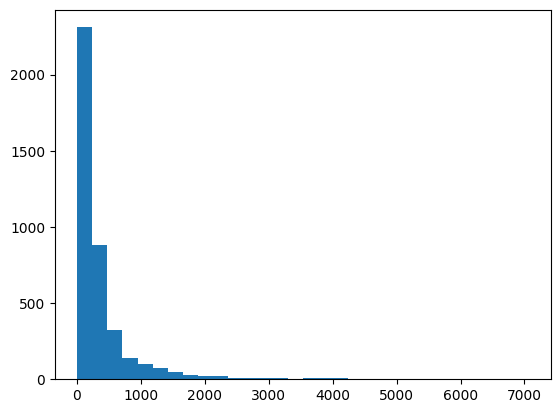

In [ ]:
plt.hist(text_len, bins=30);

In [ ]:
seq_len = int(np.percentile(text_len, 95))

In [ ]:
seq_len

1380

In [ ]:
max_tokens = 20000
embed_dim = 256

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_tokens,
                                                    output_sequence_length=seq_len,
                                                    pad_to_max_tokens=True)

text_vectorizer.adapt(X_train)

In [ ]:
embedding_layer = tf.keras.layers.Embedding(input_dim=len(text_vectorizer.get_vocabulary()),
                                            output_dim=embed_dim,
                                            mask_zero=True,
                                            input_length=seq_len)

In [ ]:
model = tf.keras.models.Sequential([
    text_vectorizer,
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    epochs=50,
                    validation_data=(X_test, y_test),
                    batch_size=32,
                    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                                                patience=5,
                                                                restore_best_weights=True)])

Epoch 1/50
126/126 [==============================] - 37s 222ms/step - loss: 0.1042 - accuracy: 0.9788 - val_loss: 0.4567 - val_accuracy: 0.8944
Epoch 2/50
126/126 [==============================] - 20s 159ms/step - loss: 0.0381 - accuracy: 0.9890 - val_loss: 0.4701 - val_accuracy: 0.8974
Epoch 3/50
126/126 [==============================] - 17s 135ms/step - loss: 0.0157 - accuracy: 0.9960 - val_loss: 0.5210 - val_accuracy: 0.8934
Epoch 4/50
126/126 [==============================] - 16s 124ms/step - loss: 0.0134 - accuracy: 0.9968 - val_loss: 0.5174 - val_accuracy: 0.8884
Epoch 5/50
126/126 [==============================] - 13s 105ms/step - loss: 0.0067 - accuracy: 0.9980 - val_loss: 0.7881 - val_accuracy: 0.8845
Epoch 6/50
126/126 [==============================] - 12s 97ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.8767 - val_accuracy: 0.8815
Epoch 7/50
126/126 [==============================] - 11s 90ms/step - loss: 0.0134 - accuracy: 0.9963 - val_loss: 0.4696 - val_accu

## Evaluate deep learning model

In [ ]:
model.evaluate(X_test, y_test)

32/32 [==============================] - 1s 21ms/step - loss: 0.4701 - accuracy: 0.8974


[0.47005441784858704, 0.8974103331565857]

In [ ]:
testing = ['this is a great book, i loved it', "the book is so bad", 'horrible product, total waste of money']
pred = tf.round(model.predict(testing))

1/1 [==============================] - 2s 2s/step


In [ ]:
tf.squeeze(pred).numpy()

array([1., 0., 0.], dtype=float32)

In [ ]:
y_test

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
y_preds = tf.squeeze(tf.round(model.predict(X_test))).numpy()
y_preds

32/32 [==============================] - 1s 25ms/step


array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [ ]:
f1_score(y_test, y_preds)

0.8945752302968271

In [ ]:
model.save('pos_neg_sentiment')

In [ ]:
!zip ./pos_neg_sentiment.zip ./pos_neg_sentiment

  adding: pos_neg_sentiment/ (stored 0%)


In [ ]:
model_2 = Pipeline([
    ('count_vec', CountVectorizer()),
    ('nb_model', MultinomialNB())
])

model_2.fit(X_train, y_train)
y_pred = model_2.predict(X_test)

print('Train Accuracy:', model_2.score(X_train, y_train))
print('Test Accuracy:', model_2.score(X_test, y_test))

Train Accuracy: 0.8914342629482072
Test Accuracy: 0.8645418326693227


In [ ]:
f1_score(y_test, y_pred)

0.8728971962616822